In [1]:
import os 
import random 
import logging 

import torch 
import mlflow 
import numpy as np 
import matplotlib.pyplot as plt 
import torchvision.transforms as transforms
import torchvision.utils 
import torch.nn as nn 

%matplotlib inline

In [3]:
os.environ['USER'] = 'Denis Rusinov'

In [4]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [6]:
from flask.cli import F


train_mnist = torchvision.datasets.MNIST('data_mnist/train', train=True, 
                                         transform=transforms.Compose([transforms.ToTensor()]),
                                         download=True)
val_mnist = torchvision.datasets.MNIST('data_mnist/test', train=False, 
                                       transform=transforms.Compose([transforms.ToTensor()]),
                                       download=True)

batch_size = 256

train_loader = torch.utils.data.DataLoader(
    dataset=train_mnist,
    batch_size=batch_size,
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    dataset=val_mnist,
    batch_size=batch_size,
    shuffle=False
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting data_mnist/train\MNIST\raw\train-images-idx3-ubyte.gz to data_mnist/train\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting data_mnist/train\MNIST\raw\train-labels-idx1-ubyte.gz to data_mnist/train\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting data_mnist/train\MNIST\raw\t10k-images-idx3-ubyte.gz to data_mnist/train\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting data_mnist/train\MNIST\raw\t10k-labels-idx1-ubyte.gz to data_mnist/train\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting data_mnist/test\MNIST\raw\train-images-idx3-ubyte.gz to data_mnist/test\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting data_mnist/test\MNIST\raw\train-labels-idx1-ubyte.gz to data_mnist/test\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting data_mnist/test\MNIST\raw\t10k-images-idx3-ubyte.gz to data_mnist/test\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%

Extracting data_mnist/test\MNIST\raw\t10k-labels-idx1-ubyte.gz to data_mnist/test\MNIST\raw



In [7]:
class FCNetwork(nn.Module):
    def __init__(self, prob, n_inside):
        super(FCNetwork, self).__init__() 
        self.fc1 = nn.Linear(784, n_inside)
        self.fc2 = nn.Linear(n_inside, 10)
        self.fc1_act = nn.ReLU()
        self.dropout = nn.Dropout(p = prob)

    def forward(self,x):
        x = x.view(-1,28*28)
        y = self.fc1(self.dropout(x))
        y = self.fc1_act(y)
        y = self.fc2(y)
        return y

In [8]:
# Инициализация MLflow
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("PyTorch_test")

2024/12/16 16:06:17 INFO mlflow.tracking.fluent: Experiment with name 'PyTorch_test' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///C:/Users/Rusinov.DS/PycharmProjects/ML_project/dns_purchase/artefacts/980200151464093923', creation_time=1734329177469, experiment_id='980200151464093923', last_update_time=1734329177469, lifecycle_stage='active', name='PyTorch_test', tags={}>

In [9]:
# Отключаем вывод ворнингов от MLflow
mlflow_logger = logging.getLogger("mlflow")
mlflow_logger.setLevel(logging.ERROR)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
prob = 0.15
n_inside = 50
lr = 1e-3
epochs = 15

In [16]:
# Функция для вычисления точности
def accuracy(y_pred, labels):
    preds = torch.argmax(y_pred, dim=1)
    return (preds == labels).float().mean().item()

In [17]:
# Начало MLflow запуска
with mlflow.start_run(run_name='FCNetwork_1') as run:
    model = FCNetwork(prob=prob, n_inside=n_inside)
    model.to(device)

    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    mlflow.log_param("prob dropout", prob)
    mlflow.log_param("neurons 2 layer", n_inside)
    mlflow.log_param("lr", lr)
    mlflow.log_param("optimizer", 'Adam')
    mlflow.log_param("epochs", epochs)

    maxacc = 0
    itr_record = 0

    for epoch in range(epochs):
        epoch += 1
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        train_samples = 0

        print(f'Началось обучение {epoch} эпохи')
        for itr, data in enumerate(train_loader):
            imgs = data[0].to(device)  # [B, H, W]
            labels = data[1].to(device)

            y_pred = model(imgs) 
            loss = loss_func(y_pred, labels)

            train_loss += loss.item() * imgs.size(0)
            train_acc += accuracy(y_pred, labels) * imgs.size(0)
            train_samples += imgs.size(0)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss /= train_samples
        train_acc /= train_samples
        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("train_acc", train_acc, step=epoch)
        print(f'The {epoch} Epoch of network learning is over:')
        print(f'Train results Epoch {epoch}: Train loss - {train_loss:.4f}, Train accuracy - {train_acc:.4f}')

        model.eval()
        val_loss = 0.0
        val_acc = 0.0
        val_samples = 0

        with torch.no_grad():
            for itr, data in enumerate(val_loader):
                imgs = data[0].to(device)
                labels = data[1].to(device)
                y_pred = model(imgs)
                loss = loss_func(y_pred, labels)

                val_loss += loss.item() * imgs.size(0)
                val_acc += accuracy(y_pred, labels) * imgs.size(0)
                val_samples += imgs.size(0)

        val_loss /= val_samples
        val_acc /= val_samples
        mlflow.log_metric("val_loss", val_loss, step=epoch)
        mlflow.log_metric("val_acc", val_acc, step=epoch)
        print(f'Validation results Epoch {epoch}: Val loss - {val_loss:.4f}, Test accuracy - {val_acc:.4f}')

        if val_acc > maxacc:
            print('Saving model because its better')
            maxacc = val_acc
            mlflow.pytorch.log_model(model, "model")
        print('---')

    print('max accuracy = ', maxacc)
    mlflow.log_metric("max val accuracy", maxacc)

mlflow.end_run()

Началось обучение 1 эпохи
The 1 Epoch of network learning is over:
Train results Epoch 1: Train loss - 0.6602, Train accuracy - 0.8283
Validation results Epoch 1: Val loss - 0.3185, Test accuracy - 0.9098
Saving model because its better
---
Началось обучение 2 эпохи
The 2 Epoch of network learning is over:
Train results Epoch 2: Train loss - 0.3177, Train accuracy - 0.9091
Validation results Epoch 2: Val loss - 0.2610, Test accuracy - 0.9266
Saving model because its better
---
Началось обучение 3 эпохи
The 3 Epoch of network learning is over:
Train results Epoch 3: Train loss - 0.2723, Train accuracy - 0.9224
Validation results Epoch 3: Val loss - 0.2274, Test accuracy - 0.9357
Saving model because its better
---
Началось обучение 4 эпохи
The 4 Epoch of network learning is over:
Train results Epoch 4: Train loss - 0.2362, Train accuracy - 0.9324
Validation results Epoch 4: Val loss - 0.1945, Test accuracy - 0.9444
Saving model because its better
---
Началось обучение 5 эпохи
The 5 Epoc

In [25]:
import pandas as pd
from pmdarima import auto_arima
import numpy as np
from sklearn.metrics import mean_absolute_error

data =  pd.read_csv('data_month.csv')

forecast_df = pd.DataFrame(columns=['month_date', 'category_id', 'final_count_forecast', 'date_load'])
for i in data.category_id.unique():
    mlflow.set_tracking_uri("http://localhost:5000")
    mlflow.set_experiment("sarima_test")

    # Отключаем вывод ворнингов от MLflow
    mlflow_logger = logging.getLogger("mlflow")
    mlflow_logger.setLevel(logging.ERROR)

    with mlflow.start_run(run_name=f'sarima_count_{i}'):

        df = data.copy()

        df = df.where(df.category_id == i).dropna()

        a = df.sort_values('date')

        df.set_index('date', inplace=True)
        df = df.sort_index()
        df.index = pd.to_datetime(df.index)

        df.product_count = df.product_count.astype(float)
        df.product_cost = df.product_cost.astype(float)
        df = df.asfreq('MS')
        df = df.fillna(0)

        train_data = df.iloc[:-2]

        if len(train_data) < 12:
            print(
                f"❌Недостаточно данных для построения прогноза по категории {i}. "
                f"Длина обучающего набора: {len(train_data)}"
            )
            continue

        test_start_date = df.index[-2]
        test_end_date = test_start_date + pd.DateOffset(
            months=len(train_data) + 25
        )
        test_dates = pd.date_range(test_start_date, test_end_date, freq="MS")

        val_data = df.iloc[-2:]

        n_jobs = 18

        mlflow.log_param('test_start_date', test_start_date)
        mlflow.log_param('test_end_date', test_end_date)
        mlflow.log_param('n_jobs', n_jobs)

        model_count = auto_arima(train_data.product_count, seasonal=True, m=12, stepwise=False , trace=False, n_jobs=n_jobs)
        forecast_count = model_count.predict(n_periods=len(train_data) + 26)


        for j in range(len(forecast_count)):
            if forecast_count.iloc[j] < 0:
                forecast_count.iloc[j] = 0

        if len(forecast_count.unique()) < len(train_data.product_count) / 2:
            continue


        forecast = pd.DataFrame(
            {
                "date": test_dates,
                "category_id": i,
                "final_count_forecast": forecast_count,
                'date_load': pd.Timestamp.now().strftime("%Y-%m-%d")
            }
        )

        val_set = pd.merge(val_data, forecast, on='month_date', how='inner')
        mlflow.log_metric(mean_absolute_error(val_set['product_count'], val_set['final_count_forecast']))



        forecast_df = pd.concat([forecast_df, forecast])
        print(f"✅Прогноз построен для категории {i}")

    mlflow.end_run()

    break



ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\Rusinov.DS\AppData\Local\Temp\tmpfu6e266z\830ej6ty.json
DEBUG:cmdstanpy:input tempfile: C:\Users\Rusinov.DS\AppData\Local\Temp\tmpfu6e266z\98ob5_1j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\Rusinov.DS\\PycharmProjects\\ML_project\\.venv\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=14658', 'data', 'file=C:\\Users\\Rusinov.DS\\AppData\\Local\\Temp\\tmpfu6e266z\\830ej6ty.json', 'init=C:\\Users\\Rusinov.DS\\AppData\\Local\\Temp\\tmpfu6e266z\\98ob5_1j.json', 'output', 'file=C:\\Users\\Rusinov.DS\\AppData\\Local\\Temp\\tmpfu6e266z\\prophet_modeluztw

2024-10-01


17:07:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


🏃 View run prophet_count_2c281485-37d2-11e4-8d43-00155d031202 at: http://localhost:5000/#/experiments/964258905629541857/runs/971700fbc4b74fea870309ea9a8fd0a7
🧪 View experiment at: http://localhost:5000/#/experiments/964258905629541857
❌Невозможно построить прогноз для категории 2c281485-37d2-11e4-8d43-00155d031202: 'ds'


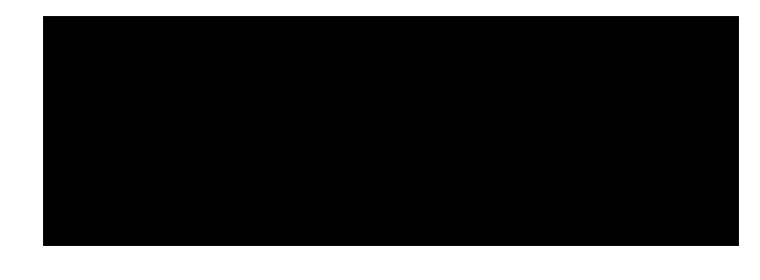

In [ ]:
from prophet import Prophet
import warnings
import pandas as pd

warnings.filterwarnings("ignore")



data = pd.read_csv('C:/Users/Rusinov.DS/PycharmProjects/ML_project/dns_purchase/dataset/data_month.csv')
data = data.sort_values('date')
dates = data['date'].unique()
min_date = dates[-2]
print(min_date)

forecast_df = pd.DataFrame(columns=['date', 'category_id', 'final_count_forecast', 'final_cost_forecast', 'date_load'])
for i in data.category_id.unique():
    try:
        df = data.copy()

        mlflow.set_tracking_uri("http://localhost:5000")
        mlflow.set_experiment("prophet_test")

        # Отключаем вывод ворнингов от MLflow
        mlflow_logger = logging.getLogger("mlflow")
        mlflow_logger.setLevel(logging.ERROR)


        with mlflow.start_run(run_name=f'prophet_count_{i}'):

            df = df.where(df.category_id == i).dropna()

            a = df.sort_values('date')

            df.set_index('date', inplace=True)
            df = df.sort_index()
            df.index = pd.to_datetime(df.index)

            df.product_count = df.product_count.astype(float)
            df.product_cost = df.product_cost.astype(float)
            df = df.asfreq('MS')
            df = df.fillna(0)

            train_data = df.iloc[:-2]

            if len(train_data) < 12:
                print(
                    f"❌Недостаточно данных для построения прогноза по категории {i}. "
                    f"Длина обучающего набора: {len(train_data)}"
                )
                continue

            test_start_date = df.index[-2]
            test_end_date = test_start_date + pd.DateOffset(
                months=25
            )
            test_dates = pd.date_range(test_start_date, test_end_date, freq="MS")

            if test_dates.min() < pd.to_datetime(min_date):
                print(f"❌Устаревшие данные для построения прогноза по категории {i}.")
                continue

            m1 = Prophet()

            count_data = pd.DataFrame(
                {
                'ds' : pd.to_datetime(train_data.index),
                'y': train_data['product_count']
                })

            count_data = count_data.sort_values('ds')

            m1.fit(count_data)

            future_count = m1.make_future_dataframe(periods=26, freq="MS")
            forecast_count = m1.predict(future_count)

            m1.plot_components(forecast)



            # mlflow.log_metric()
            mlflow
        mlflow.end_run()

        with mlflow.start_run(run_name=f'prophet_cost_{i}'):

            df = df.where(df.category_id == i).dropna()

            a = df.sort_values('date')

            df.set_index('date', inplace=True)
            df = df.sort_index()
            df.index = pd.to_datetime(df.index)

            df.product_count = df.product_count.astype(float)
            df.product_cost = df.product_cost.astype(float)
            df = df.asfreq('MS')
            df = df.fillna(0)

            train_data = df.iloc[:-2]

            if len(train_data) < 12:
                print(
                    f"❌Недостаточно данных для построения прогноза по категории {i}. "
                    f"Длина обучающего набора: {len(train_data)}"
                )
                continue

            test_start_date = df.index[-2]
            test_end_date = test_start_date + pd.DateOffset(
                months=25
            )
            test_dates = pd.date_range(test_start_date, test_end_date, freq="MS")

            if test_dates.min() < pd.to_datetime(min_date):
                print(f"❌Устаревшие данные для построения прогноза по категории {i}.")
                continue

            m2 = Prophet()
            cost_data = pd.DataFrame(
                {
                'ds' : pd.to_datetime(train_data.index),
                'y': train_data['product_cost']
                })
            cost_data = cost_data.sort_values('ds')

            m2.fit(cost_data)

            future_cost = m2.make_future_dataframe(periods=26, freq="MS")
            forecast_cost = m2.predict(future_cost)


            forecast = pd.DataFrame(
                {
                    "month_date": forecast_count.iloc[-26:]['ds'],
                    "category_id": i,
                    "final_count_forecast": forecast_count.iloc[-26:]['yhat'].apply(lambda x: 0 if x < 0 else x),
                    "final_cost_forecast": forecast_cost.iloc[-26:]['yhat'].apply(lambda x: 0 if x < 0 else x),
                    'date_load': pd.to_datetime(pd.Timestamp.now().strftime("%Y-%m-%d"))
                }
            )
        mlflow.end_run()


        forecast_df = pd.concat([forecast_df, forecast])
        print(f"✅Прогноз построен для категории {i}")
        break

    except Exception as e:
        print(f"❌Невозможно построить прогноз для категории {i}: {e}")
        
    break
